In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

In [ ]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

In [2]:
np.set_printoptions(precision=2)

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.15.0'

---

Load MNIST Data

---

In [5]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

11490434/11490434 [==============================] - 0s 0us/step
MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

A generic layer class with forward and backward methods

----

In [6]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

The softmax classifier steps for a batch of comprising $b$ samples represented as the $725\times b$-matrix (784 pixel values plus the bias feature absorbed as its last row) $$\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(0)},\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(b-1)}\end{bmatrix}$$ with one-hot encoded true labels represented as the $10\times b$-matrix (10 possible categories) $$\mathbf{Y}=\begin{bmatrix}\mathbf{y}^{(0)}&\ldots&\mathbf{y}^{(b-1)}\end{bmatrix}$$ using a randomly initialized $10\times725$-weights matrix $\mathbf{W}$:

1. Calculate $10\times b$-raw scores matrix : $$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{x}^{(0)}&\ldots&\mathbf{x}^{(b-1)}\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{x}^{(0)}&\ldots&\mathbf{W}\mathbf{x}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$
2. Calculate $10\times b$-softmax predicted probabilities matrix: $$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$
3. Predicted probability matrix gets a new name: $\hat{\mathbf{Y}} = \mathbf{A}.$
4. The crossentropy (CCE) loss for the $i$th sample is $$L_i = \sum_{k=0}^9-y^{(i)}_k\log\left(\hat{y}^{(i)}_k\right) = -{\mathbf{y}^{(i)}}^\mathrm{T}\log\left(\mathbf{y}^{(i)}\right)$$ which leads to the average crossentropy (CCE) batch loss for the batch as:
$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}.$$
5. The computational graph for the samples in the batch are presented below:

$\hspace{1.5in}\begin{align*}L_0\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(0)} &= \mathbf{a}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$$\qquad\cdots\qquad$$\begin{align*} L_{b-1}\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(b-1)} &= \mathbf{a}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$
6. Calculate the gradient of the average batch loss w.r.t. weights as: $$\begin{align*}\Rightarrow \nabla_\mathbf{W}(L) &= \frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left(\hat{\mathbf{y}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right)\\&=\frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right).\end{align*}$$
which can be written as $\nabla_\mathbf{W}(L)=$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103292&authkey=%21AMoosVj6GqUSvpc&width=660)


---

---

CCE loss and its gradient for the batch samples:

$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}$$

$$\begin{align*}\begin{bmatrix}\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)&\ldots&\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\end{bmatrix}=\begin{bmatrix}-y_0^{(0)}/\hat{y}_0^{(0)}&\cdots&-y_0^{(b-1)}/\hat{y}_0^{(b-1)}\\-y_1^{(0)}/\hat{y}_1^{(0)}&\ldots&-y_1^{(b-1)}/\hat{y}_1^{(b-1)}\\-y_2^{(0)}/\hat{y}_2^{(0)}&\cdots&-y_2^{(b-1)}/\hat{y}_2^{(b-1)}\\\vdots\\-y_9^{(0)}/\hat{y}_9^{(0)}&\cdots&-y_9^{(b-1)}/\hat{y}_9^{(b-1)}\end{bmatrix}.\end{align*}$$


---

In [7]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

Generic activation layer class:

**Forward**:
$$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\sigma\left(\mathbf{z}^{(0)}\right)&\ldots&\sigma\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \sigma(\mathbf{Z}).\end{align*}$$

**Backward**:
$$\begin{align*}\begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}(L_0)&\ldots&\nabla_{\mathbf{z}^{(b-1)}}(L_{b-1})\end{bmatrix} &= \begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\cdots&\nabla_{\mathbf{z}^{(b-1)}}\left({\mathbf{a}}^{(b-1)}\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}\\&=\begin{bmatrix}\text{diag}\left(\nabla_{\mathbf{z}^{(0)}}\left(\sigma\left(\mathbf{z}^{(0)}\right)\right)\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\ldots&\text{diag}\left(\nabla_{\mathbf{z}^{(b-1)}}\left(\sigma\left(\mathbf{z}^{(b-1)}\right)\right)\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}.\end{align*}$$



In [8]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(self.activation_gradient(self.input) * output_gradient[:-1, :])

Specific activation layer classes:

In [20]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1+np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1-a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            return

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

---

Softmax activation layer class:

**Forward**:
$$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$

**Backward**:
$$\begin{align*}\begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}(L_0)&\ldots&\nabla_{\mathbf{z}^{(b-1)}}(L_{b-1})\end{bmatrix} &= \begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\cdots&\nabla_{\mathbf{z}^{(b-1)}}\left({\mathbf{a}}^{(b-1)}\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}\end{align*}$$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103299&authkey=%21AIPPR63BJ3UybA8&width=928&height=99)


---

In [ ]:
z = np.array([[10., 20., 30.], [-10., 50., 45.]])
print(z)
tf.nn.softmax(z, axis = 0).numpy()

[[ 10.  20.  30.]
 [-10.  50.  45.]]


array([[1.00e+00, 9.36e-14, 3.06e-07],
       [2.06e-09, 1.00e+00, 1.00e+00]])

In [11]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.output = tf.nn.softmax(input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype = np.float64)
    for b in range(softmax_gradient.shape[1]):
      softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-np.atleast_2d(self.output[:, b])) * np.atleast_2d(self.output[:, b]).T, output_gradient[:, b])
    return(softmax_gradient)
    ## Following is the efficient way of calculating the backward gradient
    #T = np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (2, 1, 0)) * np.atleast_2d(self.output)
    #return(np.einsum('jik, ik -> jk', T, output_gradient))

---

Dense layer class:

**Forward**:
$$$$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{z}^{(0)}&\ldots&\mathbf{W}\mathbf{z}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$$$

**Backward**:
$$\begin{align*}\nabla_\mathbf{W}(L)&=\frac{1}{b}\left[\nabla_{\mathbf{W}}(\mathbf{z}^{(0)})\times\nabla_{\mathbf{z^{(0)}}}(L) +\cdots+ \nabla_{\mathbf{W}}(\mathbf{z}^{(b-1)})\times\nabla_{\mathbf{z^{(b-1)}}}(L)\right]\\&=\frac{1}{b}\left[\nabla_{\mathbf{z^{(0)}}}(L){\mathbf{x}^{(0)}}^\mathrm{T}+\cdots+\nabla_{\mathbf{z^{(b-1)}}}(L) {\mathbf{x}^{(b-1)}}^\mathrm{T}\right].\end{align*}$$

---

In [33]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength = 0.0):
        self.weights = 0.01*np.random.randn(output_size, input_size + 1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate the regularization loss (L2 regularization)
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        for b in range(output_gradient.shape[1]):
          weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        # Add the regularization loss gradient here
        weights_gradient += 2*self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])

        ## Following is the efficient way of calculating the weights gradient
        #weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)

        input_gradient = np.dot(self.weights.T, output_gradient)

        # Update weights using gradient descent step
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

---

Function to generate sample indices for batch processing according to batch size

---

In [12]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Example generation of batch indices

---

In [18]:
## Example generation of batch indices
batch_size = 8
batch_indices = generate_batch_indices(32, batch_size)
print(batch_indices)

[array([26, 19, 21, 20,  2,  9, 22, 14]), array([10, 29, 18,  6, 31, 11,  4,  5]), array([ 3, 27, 23,  7, 12, 25,  0, 17]), array([15,  1, 24, 30, 28, 16, 13,  8])]


---

Train the 2-layer neural network (128 nodes in the hidden layer) using batch training with batch size = 100

---

In [35]:
## Train the 2-layer neural network (128 nodes in the hidden layer)
## using batch training with batch size = 100
learning_rate = 1e-3 # learning rate
batch_size = 100 # batch size
nepochs = 50 # number of epochs
reg_strength = 0 # regularization strength

# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)

# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)

# Define neural network architecture
dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # define activation layer 1
dlayer2 = Dense(128, num_labels, reg_strength) # define dense layer 2
softmax = Softmax() # define softmax activation layer

# Steps: run over each batch, calculate average loss, average gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  # Run over each batch
  for b in range(len(batch_indices)):
    # Forward prop starts here
    dlayer1.forward(X_train[:, batch_indices[b]])
    alayer1.forward(dlayer1.output)
    dlayer2.forward(alayer1.output)
    softmax.forward(dlayer2.output)

    # Calculate training data loss
    loss += cce(Y_train[:, batch_indices[b]], softmax.output)
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)

  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss / len(batch_indices)

  # Forward propagation for the test data
  dlayer1.forward(X_test)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)
  softmax.forward(dlayer2.output)

  # Calculate the test data loss for the current epoch
  loss_test_epoch[epoch] = cce(Y_test, softmax.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 2.299389, test loss = 2.295193
Epoch 2: train loss = 2.290846, test loss = 2.285164
Epoch 3: train loss = 2.278840, test loss = 2.270139
Epoch 4: train loss = 2.260246, test loss = 2.246567
Epoch 5: train loss = 2.231139, test loss = 2.210017
Epoch 6: train loss = 2.186766, test loss = 2.155294
Epoch 7: train loss = 2.121940, test loss = 2.077232
Epoch 8: train loss = 2.032109, test loss = 1.971948
Epoch 9: train loss = 1.914963, test loss = 1.839202
Epoch 10: train loss = 1.773412, test loss = 1.685753
Epoch 11: train loss = 1.617639, test loss = 1.525448
Epoch 12: train loss = 1.462395, test loss = 1.373296
Epoch 13: train loss = 1.320055, test loss = 1.238714
Epoch 14: train loss = 1.196626, test loss = 1.124381
Epoch 15: train loss = 1.092628, test loss = 1.028817
Epoch 16: train loss = 1.005702, test loss = 0.949120
Epoch 17: train loss = 0.933012, test loss = 0.882317
Epoch 18: train loss = 0.871836, test loss = 0.826076
Epoch 19: train loss = 0.819985, test

---

Plot train and test loss as a function of epoch

---

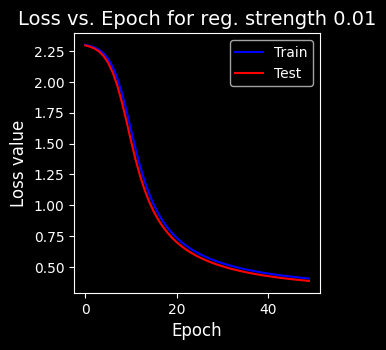

In [36]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 0.01', fontsize = 14);

---

Test performance on test data

---

In [ ]:
## Forward propagate using the weights from the last epoch
dlayer1.forward(X_test)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
softmax.forward(dlayer2.output)

# Predict the output labels for the test data
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(ytrue, ypred)

array([[ 966,    0,    2,    6,    0,    0,    3,    1,    2,    0],
       [   0, 1123,    4,    4,    0,    0,    1,    1,    2,    0],
       [  99,   70,  695,   66,    9,    0,   52,   27,    7,    7],
       [  75,   32,   26,  816,    0,    0,    2,   35,   17,    7],
       [  24,   18,    4,    0,  324,    0,   37,   18,    5,  552],
       [ 364,   38,   31,  259,    5,    0,   28,   72,   43,   52],
       [ 158,   15,   58,   10,   14,    0,  697,    1,    5,    0],
       [  20,   62,   16,    1,    0,    0,    0,  908,    5,   16],
       [  87,   91,   65,  238,    2,    0,   16,   42,  368,   65],
       [  34,   23,    2,   11,   35,    0,    6,  230,    2,  666]])